In [1]:
%reload_ext autoreload
%autoreload 2

In [14]:
import pynwb
import os

#DataJoint and DataJoint schema
import datajoint as dj
import numpy as np
import pandas as pd

## We also import a bunch of tables so that we can call them easily

from spyglass.common import (RawPosition, HeadDir, Speed, LinPos, StateScriptFile, VideoFile,
                                  DataAcquisitionDevice, CameraDevice, Probe,
                                  DIOEvents,
                                  ElectrodeGroup, Electrode, Raw, SampleCount,
                                  LFPSelection, LFP, LFPBandSelection, LFPBand,
                                  FirFilter,
                                  IntervalList,
                                  Lab, LabMember, LabTeam, Institution,
                                  BrainRegion,
                                  SensorData,
                                  Session, ExperimenterList,
                                  Subject,
                                  Task, TaskEpoch,
                                  Nwbfile, AnalysisNwbfile, NwbfileKachery, AnalysisNwbfileKachery,
                                  get_electrode_indices)
from spyglass.common.common_position import (PositionInfoParameters,IntervalPositionInfo)
from spyglass.common.common_interval import interval_list_intersect



from plot_lfp import (get_x_y_list, get_speed, get_timestamps_and_data,get_electrode_ids,remove_dead_tet_chans,check_for_dead_probes,
                      checking_other_dead_tets,simple_plot,plot_overlay,plot_overlay_with_pos,plot_speed_versus_theta, find_overlapping_times,get_x_y_timestamp_list)

import re
import matplotlib.pyplot as plt
import warnings
from ripple_detection.detectors import Kay_ripple_detector

warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)
#do this from the tutorial notebook. close everything, close jupyter server... clean start!

from spyglass.common.signal_processing import hilbert_decomp
from scipy import signal as sig
import statistics



In [15]:
nwb_file_name = 'senor20201030_.nwb'

In [16]:
raw_timestamps, raw_data, raw_eseries = get_timestamps_and_data(nwb_file_name,data_type = ['raw'])
lfp_timestamps, lfp_data, lfp_eseries = get_timestamps_and_data(nwb_file_name,data_type = ['lfp'])
theta_timestamps, theta_data, theta_eseries = get_timestamps_and_data(nwb_file_name,filter_type=['Theta 5-11 Hz'],data_type = ['theta'])
ripple_timestamps, ripple_data, ripple_eseries = get_timestamps_and_data(nwb_file_name,filter_type=['Ripple 150-250 Hz'],data_type = ['ripple'])

In [4]:
position_info = (IntervalPositionInfo() &
                 {'nwb_file_name': nwb_file_name,
                  'interval_list_name': 'pos 1 valid times',
                  'position_info_param_name': 'default'}
                ).fetch1_dataframe()

In [5]:
epoch = (IntervalList & {'nwb_file_name':nwb_file_name} & {'interval_list_name':'02_r1'}).fetch1('valid_times')

In [ ]:
#make sure the lfp looks like the filtered version of the raw 

In [ ]:
lfp_electrode_ids

In [ ]:

%matplotlib inline
electrode_id = [40]
time_from_start = 215 #in seconds
time_interval_s = 10
sampling_rate_lfp = 1000 #lfp sampling rate
sampling_rate_orig = (LFP() & {'nwb_file_name': nwb_file_name}).fetch1('filter_sampling_rate')


plot_overlay_with_pos(lfp_eseries, raw_eseries, theta_eseries, ripple_eseries, position_info, nwb_file_name, time_from_start, time_interval_s, epoch, electrode_id,offset = 500)

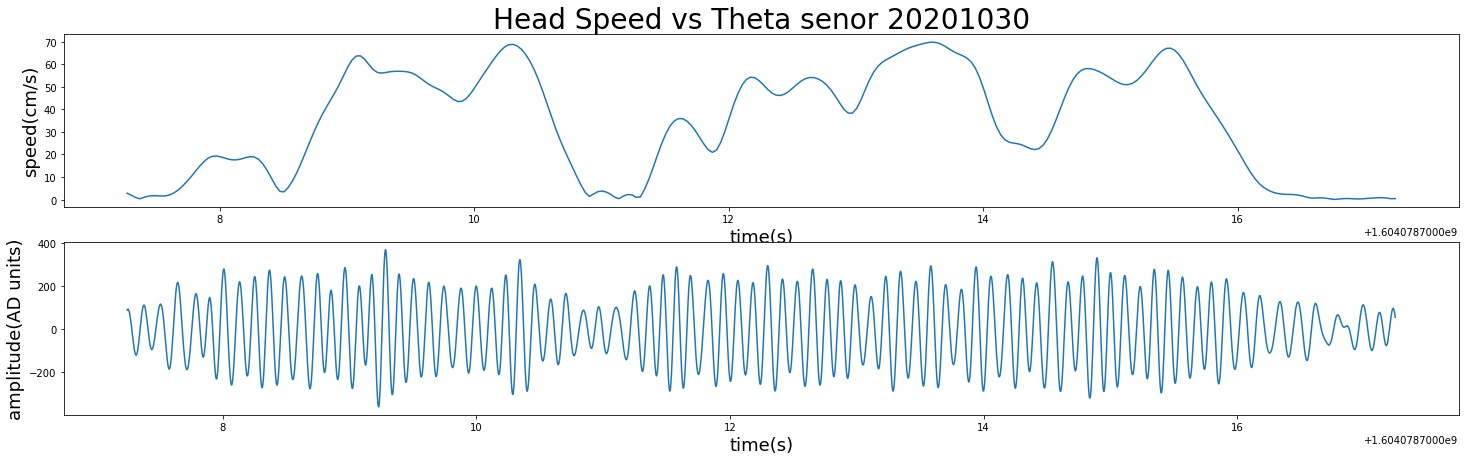

In [39]:
electrode_id = [17]
time_from_start = 500 #in seconds
time_interval_s = 10
sampling_rate_lfp = 1000 #lfp sampling rate
sampling_rate_orig = (LFP() & {'nwb_file_name': nwb_file_name}).fetch1('filter_sampling_rate')
offset = 0


x_elect_lfp, y_elect_lfp =get_x_y_list(time_from_start, time_interval_s,epoch, electrode_id, lfp_eseries, lfp_timestamps, lfp_data)
x_elect_raw, y_elect_raw =get_x_y_list(time_from_start, time_interval_s,epoch, electrode_id, raw_eseries, raw_timestamps, raw_data)
x_elect_theta, y_elect_theta =get_x_y_list(time_from_start, time_interval_s,epoch, electrode_id, theta_eseries, theta_timestamps, theta_data)
x_pos,y_pos = get_speed(position_info,epoch,time_from_start,time_interval_s)

temp = re.findall(r'\d+', nwb_file_name)
day = list(map(int, temp))
rat_name = re.findall('([a-zA-Z ]*)\d*.*', nwb_file_name)[0]

plot_speed_versus_theta(x_pos, y_pos, x_elect_theta[0], y_elect_theta[0], f'Head Speed vs Theta {rat_name} {day[0]}','time(s)','speed(cm/s)','time(s)','amplitude(AD units)')



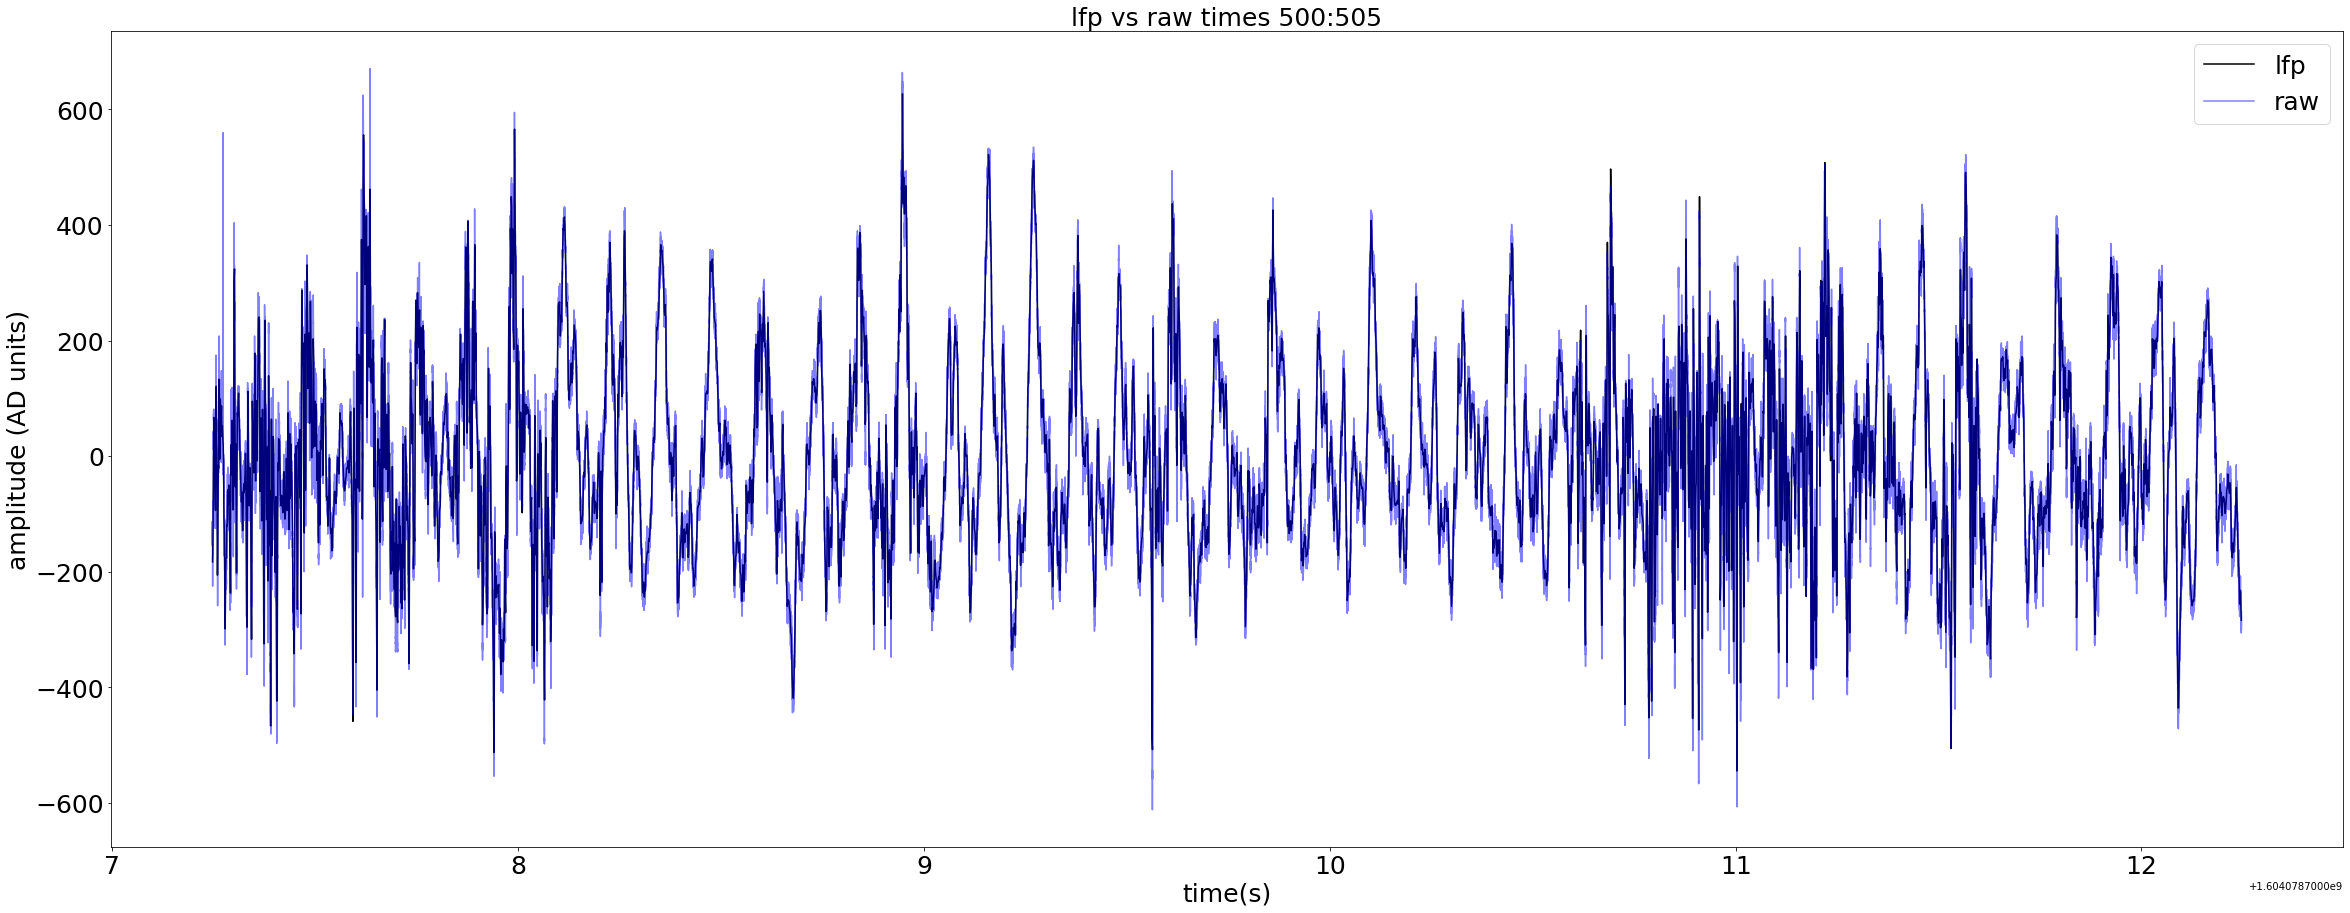

In [35]:
electrode_id = [0]
time_from_start = 500 #in seconds
time_interval_s = 5
sampling_rate_lfp = 1000 #lfp sampling rate
sampling_rate_orig = (LFP() & {'nwb_file_name': nwb_file_name}).fetch1('filter_sampling_rate')
offset = 0


x_elect_lfp, y_elect_lfp =get_x_y_list(time_from_start, time_interval_s,epoch, electrode_id, lfp_eseries, lfp_timestamps, lfp_data)
x_elect_raw, y_elect_raw =get_x_y_list(time_from_start, time_interval_s,epoch, electrode_id, raw_eseries, raw_timestamps, raw_data)
x_elect_theta, y_elect_theta =get_x_y_list(time_from_start, time_interval_s,epoch, electrode_id, theta_eseries, theta_timestamps, theta_data)
x_pos,y_pos = get_speed(position_info,epoch,time_from_start,time_interval_s)

plot_overlay(x_elect_lfp[0],y_elect_lfp[0],'lfp','black',x_elect_raw[0],y_elect_raw[0],'raw','blue',f'lfp vs raw times {time_from_start}:{time_from_start+time_interval_s}','time(s)','amplitude (AD units)',offset = 0)

In [ ]:
#should add the plot with all the electrodes, but need to make it into a function first 

In [ ]:
#ripple detection! 

In [ ]:
from plot_lfp import ripple_detector

pos_interval = 'pos 1 valid times'

lfp_electrode_ids = lfp_ripple_object['filtered_data'].electrodes[:].index
electrode_groups = [(Electrode() & {'nwb_file_name' : nwb_file_name,
                                    'electrode_id' : lfp_electrode}).fetch1('electrode_group_name')
                     for lfp_electrode in lfp_electrode_ids]

tetrode_ind = np.asarray( [int(group_name) <= 23 for group_name in electrode_groups] )
tetrode_ind[[4, 5, 17]] = False
tetrode_ind

ripple_times_df = ripple_detector(nwb_file_name, pos_interval, tetrode_ind)

In [43]:
ripple_times_df = ripple_detector(nwb_file_name, pos_interval, tetrode_ind)

In [12]:
# lfp_sampling_rate = (LFPBand & {'nwb_file_name' : nwb_file_name,
#                                'filter_name' : 'Ripple 150-250 Hz'}).fetch('lfp_band_sampling_rate')

# # Get animal speed upsampled to LFP sampling rate
# lfp_pos_df = (IntervalPositionInfo & {'nwb_file_name' : nwb_file_name,
#                                       'interval_list_name' : 'pos 0 valid times',
#                                       'position_info_param_name' : 'default_lfp'}).fetch1_dataframe()

# # Head speed in cm/s - because that is a param of the ripple detection detection 
# head_speed = np.asarray(lfp_pos_df.head_speed)

# # Position timestamps in s
# pos_time = lfp_pos_df.index

# # Get ripple-filtered LFP
# lfp_ripple_object = (LFPBand & {'nwb_file_name' : nwb_file_name,
#                                 'filter_name' : 'Ripple 150-250 Hz'}).fetch_nwb()[0]

# # Ripple-filtered LFP in AD units
# # No need to convert to volts because ripple detection occurs on standardized data
# lfp_ripple = np.asarray( lfp_ripple_object['filtered_data'].data, dtype='double' )

# lfp_time = lfp_ripple_object['filtered_data'].timestamps[:]

# lfp_interval_list = (IntervalList & {'nwb_file_name' : nwb_file_name,
#                                      'interval_list_name' : 'lfp valid times'}).fetch1('valid_times')
# position_interval_list = (IntervalList & {'nwb_file_name' : nwb_file_name,
#                                           'interval_list_name' : 'pos 0 valid times'}).fetch1('valid_times')

# overlap_interval_list = interval_list_intersect(lfp_interval_list, position_interval_list)

# pos_ind, lfp_ind = find_overlapping_times([pos_time, lfp_time], overlap_interval_list)
# ##############
# position_df = pd.DataFrame(pos_time[pos_ind],index =pos_time[pos_ind] )
# position_df['speed']= head_speed[pos_ind]

# # position_df.time
# position_df

# new_index = pd.Index(np.unique(np.concatenate(
#                 (position_df.time, lfp_time[lfp_ind]))), name='time1')

# new_index

# speed_df = (position_df.reindex(index=new_index)
#                .interpolate(method='linear')
#                .reindex(index=lfp_time[lfp_ind]))
# speed_df
# ##########
# lfp_electrode_ids = lfp_ripple_object['filtered_data'].electrodes[:].index
# electrode_groups = [(Electrode() & {'nwb_file_name' : nwb_file_name,
#                                     'electrode_id' : lfp_electrode}).fetch1('electrode_group_name')
#                      for lfp_electrode in lfp_electrode_ids]

# tetrode_ind = np.asarray( [int(group_name) <= 23 for group_name in electrode_groups] )
# tetrode_ind[[4, 5, 17]] = False
# tetrode_ind


# ripple_data_ind = np.ix_(lfp_ind, tetrode_ind)
# ripple_data_ind
# ########
# ripple_times_df = Kay_ripple_detector(lfp_time[lfp_ind],
#                                       lfp_ripple[ripple_data_ind],
#                                       np.array(speed_df.speed.to_list()),
#                                       lfp_sampling_rate,
#                                       speed_threshold=4.0,
#                                       minimum_duration=0.015,
#                                       zscore_threshold=2.0,
#                                       smoothing_sigma=0.004,
#                                       close_ripple_threshold=0.0)

In [ ]:
ripple_eseries = lfp_ripple_object['filtered_data']
ripple_data = ripple_eseries.data
ripple_timestamps = ripple_eseries.timestamps
ripple_elecs = lfp_electrode_ids[tetrode_ind]


ripple_num = [0,1,2,3,4,5,6]
for rip in range(len(ripple_num)):

    plottimes = [ripple_times_df['start_time'].values[ripple_num[rip]], 
                 ripple_times_df['end_time'].values[ripple_num[rip]]]
    x_elect, y_elect= get_x_y_timestamp_list(plottimes[0], plottimes[1], ripple_elecs, ripple_eseries, ripple_timestamps, ripple_data)


    plt.figure(figsize=(20,15))
    for ix in range(len(x_elect)):
        plt.plot(x_elect[0],y_elect[ix]+500*ix,label=ripple_elecs[ix])
        plt.text(x_elect[0][-1], y_elect[ix][-1]+500*ix, f'tetrode {int(ripple_elecs[ix]/4)+1}')
        plt.title(f'ripples across tetrode channels {nwb_file_name} {plottimes[0]}:{plottimes[1]}\nripple #{ripple_num[rip]}')
        plt.xlabel('time(s)')
        plt.ylabel('amplitude(AD units)')
        plt.vlines(plottimes[0],0,510*ix)
        plt.vlines(plottimes[1],0,510*ix)

In [ ]:
#I want times to be 0:100s
#and then to see all rips in this time 


In [73]:
1000/60

16.666666666666668

In [72]:
ripple_elecs = lfp_electrode_ids[tetrode_ind]
electrode_id = ripple_elecs
time_from_start = 0 #in seconds
time_interval_s = 1000
sampling_rate_lfp = 1000 #lfp sampling rate
sampling_rate_orig = (LFP() & {'nwb_file_name': nwb_file_name}).fetch1('filter_sampling_rate')
offset = 0


x_elect_ripple, y_elect_ripple =get_x_y_list(time_from_start, time_interval_s,epoch, electrode_id, ripple_eseries, ripple_timestamps, ripple_data)
# x_elect_raw, y_elect_raw =get_x_y_list(time_from_start, time_interval_s,epoch, electrode_id, raw_eseries, raw_timestamps, raw_data)
# x_elect_theta, y_elect_theta =get_x_y_list(time_from_start, time_interval_s,epoch, electrode_id, theta_eseries, theta_timestamps, theta_data)
x_pos,y_pos = get_speed(position_info,epoch,time_from_start,time_interval_s)

# plt.plot(x_elect_ripple,y_elect_ripple)#,label=ripple_elecs[ix])



Text(0, 0.5, 'amplitude (AD units), speed(cm/s * 100) on top')

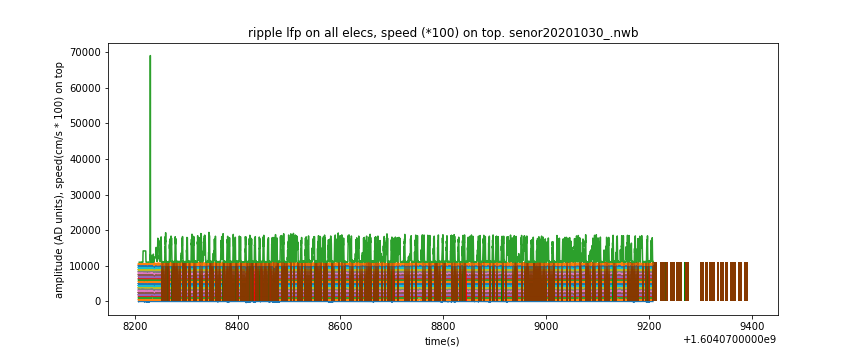

In [86]:
%matplotlib widget
plt.figure(figsize=(12,5))
# plt.plot(x_elect_ripple[0],y_elect_ripple[0])#,label=ripple_elecs[ix])
for ix in range(len(x_elect_ripple)):
    plt.plot(x_elect_ripple[0],y_elect_ripple[ix]+500*ix,label=ripple_elecs[ix])
    for rip in range(1,len(ripple_times_df)):
        plottimes = [ripple_times_df['start_time'].values[rip], 
                     ripple_times_df['end_time'].values[rip]]
        plt.vlines(plottimes[0],0,11000,color='green',alpha=.2)
        plt.vlines(plottimes[1],0,11000,color='red',alpha=.2)
# plt.figure(figsize=(5,5))
plt.plot(x_pos,(y_pos*100)+500*(ix+1))
plt.title(f'ripple lfp on all elecs, speed (*100) on top. {nwb_file_name}')
plt.xlabel('time(s)')
plt.ylabel('amplitude (AD units), speed(cm/s * 100) on top')

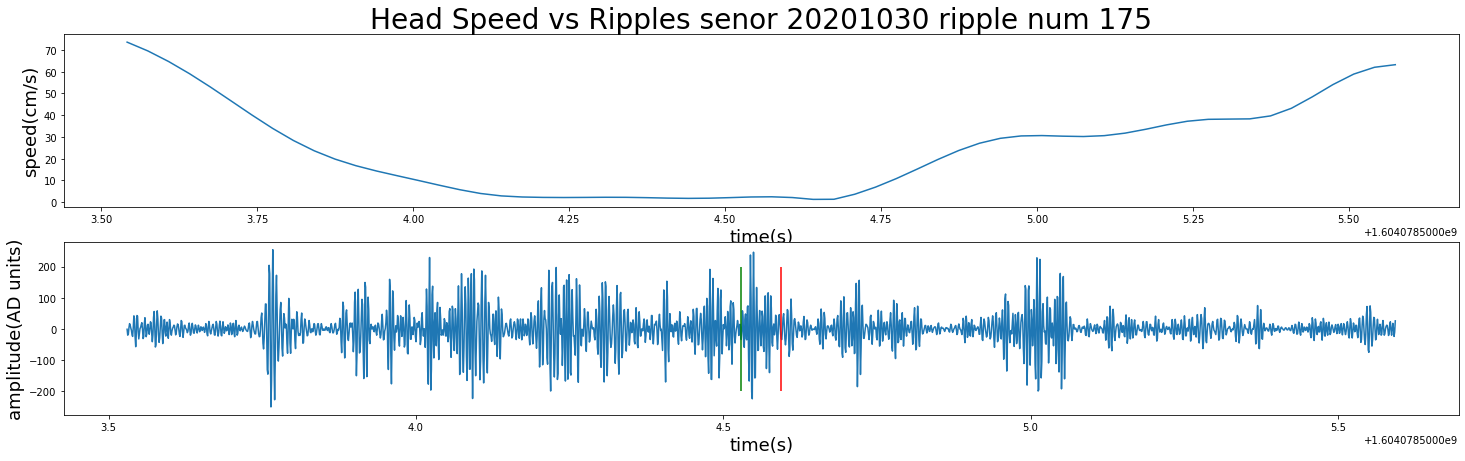

In [69]:
#now what i want is a function that take in ripple number, finds the data corresponding to 1 second around it, and plots it with speed 

#this method is okay, but would be nice to have more flexible version (plot mutliple ripples?) 

from plot_lfp import get_speed_timestamp
electrode_id = [44] 
ripple_num = 175
start_timestamp = ripple_times_df['start_time'].values[ripple_num]
end_timestamp = ripple_times_df['end_time'].values[ripple_num]


x_elect_ripp , y_elec_ripp = get_x_y_timestamp_list(start_timestamp, end_timestamp, electrode_id, ripple_eseries, ripple_timestamps, ripple_data)

speed_x, speed_y = get_speed_timestamp(start_timestamp, end_timestamp, position_info)

# electrode_id = [17]
# time_from_start = 500 #in seconds
# time_interval_s = 10
# sampling_rate_lfp = 1000 #lfp sampling rate
# sampling_rate_orig = (LFP() & {'nwb_file_name': nwb_file_name}).fetch1('filter_sampling_rate')
# offset = 0


# x_elect_lfp, y_elect_lfp =get_x_y_list(time_from_start, time_interval_s,epoch, electrode_id, lfp_eseries, lfp_timestamps, lfp_data)
# x_elect_raw, y_elect_raw =get_x_y_list(time_from_start, time_interval_s,epoch, electrode_id, raw_eseries, raw_timestamps, raw_data)
# x_elect_theta, y_elect_theta =get_x_y_list(time_from_start, time_interval_s,epoch, electrode_id, theta_eseries, theta_timestamps, theta_data)
# x_pos,y_pos = get_speed(position_info,epoch,time_from_start,time_interval_s)

temp = re.findall(r'\d+', nwb_file_name)
day = list(map(int, temp))
rat_name = re.findall('([a-zA-Z ]*)\d*.*', nwb_file_name)[0]

plot_speed_versus_theta(speed_x, speed_y, x_elect_ripp[0] , y_elec_ripp[0], f'Head Speed vs Ripples {rat_name} {day[0]} ripple num {ripple_num}','time(s)','speed(cm/s)','time(s)','amplitude(AD units)')
plt.vlines(ripple_times_df['start_time'].values[ripple_num], -200, 200, color='green')
plt.vlines(ripple_times_df['end_time'].values[ripple_num], -200, 200, color='red')



In [50]:
x_elect_ripp

[array([1.60407827e+09, 1.60407827e+09, 1.60407827e+09, ...,
        1.60407828e+09, 1.60407828e+09, 1.60407828e+09])]

In [26]:
#look at a run, good priors about when to see them - speed underneath- do we believe the ripple detector 
#point AC to proof when i have ripple run verified

#could downsample, or could look at every other elec or something!

In [ ]:
#summary statistics... mean and sd of each electrode- entire trace , histogram (subplot for tets/probes) 

#what if theres a ton/ no theta in one electrode
#dead channel (var = 0?) 
#amplifiers saturated 

#checking our references on raw/lfp.. is it being super crazy? 




In [140]:
(Electrode() & {'nwb_file_name':nwb_file_name}) - {'probe_type' : '128c-4s6mm6cm-15um-26um-sl'}

nwb_file_name name of the NWB file,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode,probe_type,probe_shank shank number within probe,probe_electrode electrode,region_id,name unique label for each contact,original_reference_electrode the configured reference electrode for this electrode,x the x coordinate of the electrode position in the brain,y the y coordinate of the electrode position in the brain,z the z coordinate of the electrode position in the brain,filtering description of the signal filtering,impedance electrode impedance,"bad_channel if electrode is ""good"" or ""bad"" as observed during recording",x_warped x coordinate of electrode position warped to common template brain,y_warped y coordinate of electrode position warped to common template brain,z_warped z coordinate of electrode position warped to common template brain,contacts label of electrode contacts used for a bipolar signal - current workaround
senor20201030_.nwb,0,0,tetrode_12.5,0,0,6,0,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,0,1,tetrode_12.5,0,1,6,1,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,0,2,tetrode_12.5,0,2,6,2,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,0,3,tetrode_12.5,0,3,6,3,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,1,4,tetrode_12.5,0,0,6,4,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,1,5,tetrode_12.5,0,1,6,5,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,1,6,tetrode_12.5,0,2,6,6,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,1,7,tetrode_12.5,0,3,6,7,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,10,40,tetrode_12.5,0,0,6,40,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,10,41,tetrode_12.5,0,1,6,41,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,


In [141]:
lfp_electrode_ids =get_electrode_ids(nwb_file_name, which_elects =1, ref=True)
electrode_groups = [(Electrode() & {'nwb_file_name' : nwb_file_name,
                                    'electrode_id' : lfp_electrode}).fetch1('electrode_group_name')
                     for lfp_electrode in lfp_electrode_ids]

tetrode_ind = np.asarray( [int(group_name) <= 23 for group_name in electrode_groups] )
# tetrode_ind[[4, 5, 17]] = False
tetrode_ind

lfp_electrode_ids_test = lfp_electrode_ids[tetrode_ind]

#02_r1 noPrePostTrialTimes as an interval 


original electrode ids, minus ref = [  0   1   2   3   4   5   6   7  40  41  42  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79   8   9  10  11  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119  12  13  14  15 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 26

In [142]:
lfp_electrode_ids_test = lfp_electrode_ids[tetrode_ind]
tetrode_ind = np.asarray( [int(group_name) <= 23 for group_name in electrode_groups] )
# tetrode_ind[[4, 5, 17]] = False
tetrode_ind
print(tetrode_ind)
lfp_electrode_ids_test

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [144]:
theta_electrodes_test = lfp_electrode_ids_test[lfp_electrode_ids_test %4==0]
theta_electrodes_test

array([ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64,
       68, 72, 76, 80, 84, 88, 92])

In [12]:
# raw_timestamps, raw_data, raw_eseries = get_timestamps_and_data(nwb_file_name,data_type = ['raw'])


In [145]:

# x_elect_raw, y_elect_raw =get_x_y_list(30, 10 ,epoch, lfp_electrode_ids_test, raw_eseries, raw_timestamps, raw_data)
time_from_start = 100
time_interval_s= 1000
x_elect_theta, y_elect_theta =get_x_y_list(time_from_start, time_interval_s ,epoch, theta_electrodes_test, theta_eseries, theta_timestamps, theta_data)



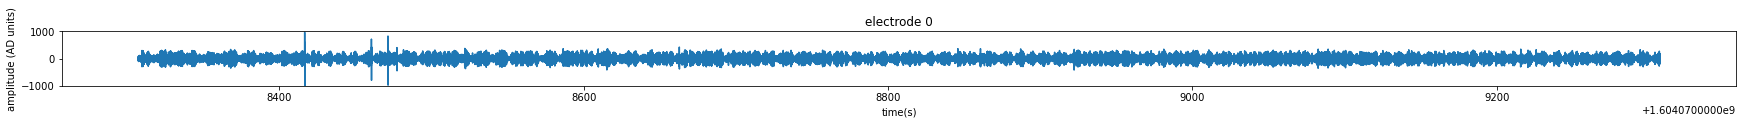

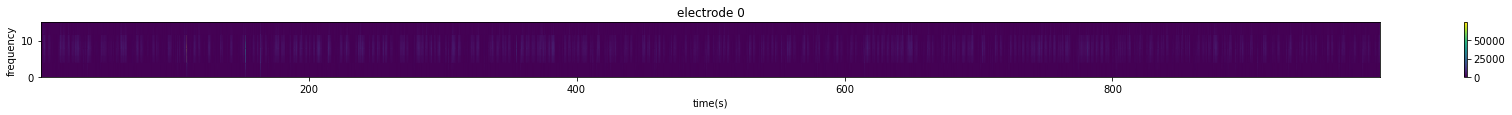

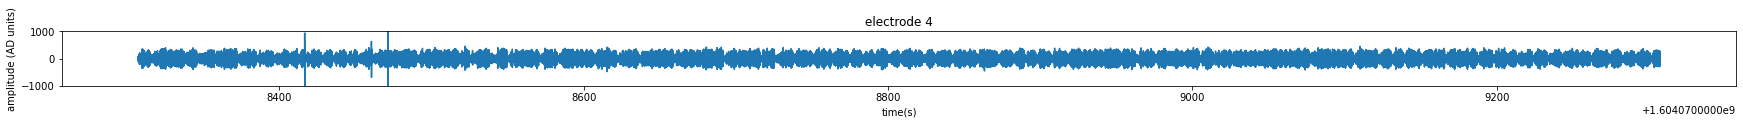

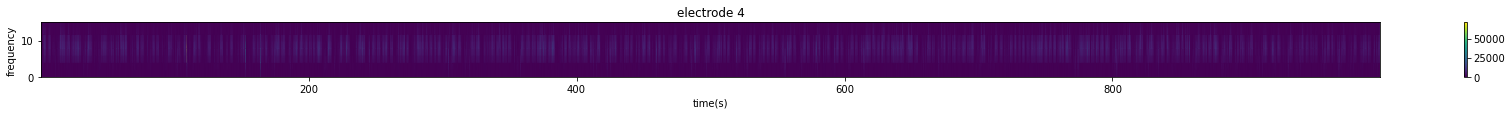

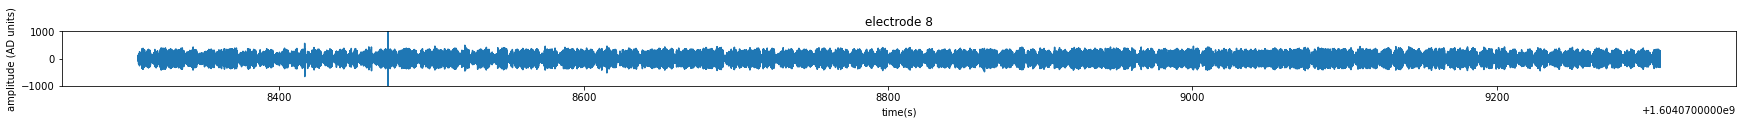

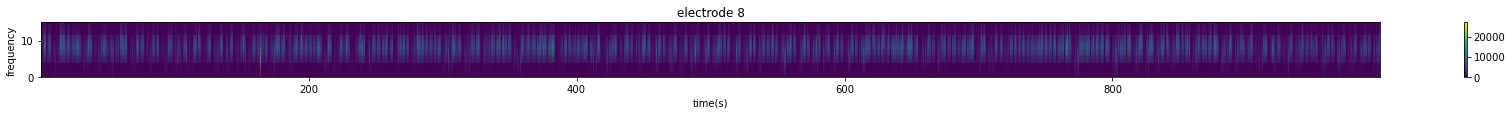

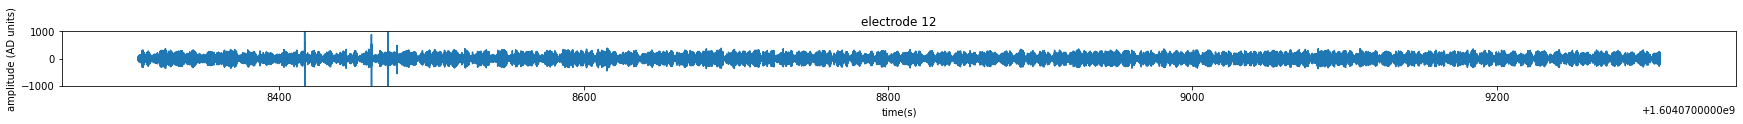

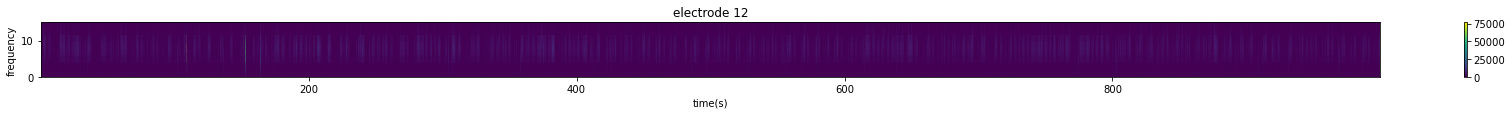

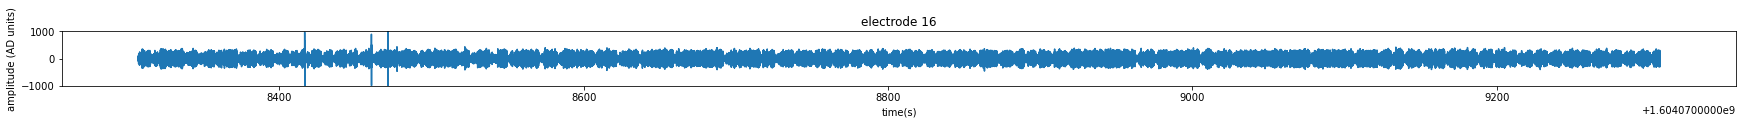

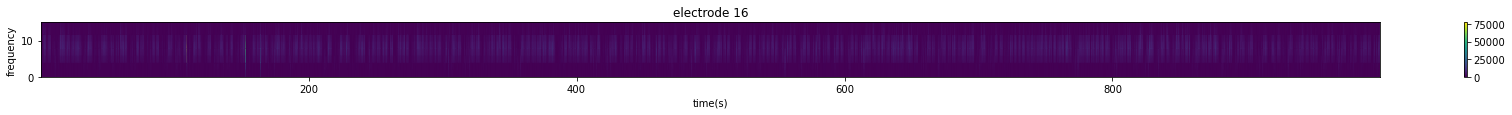

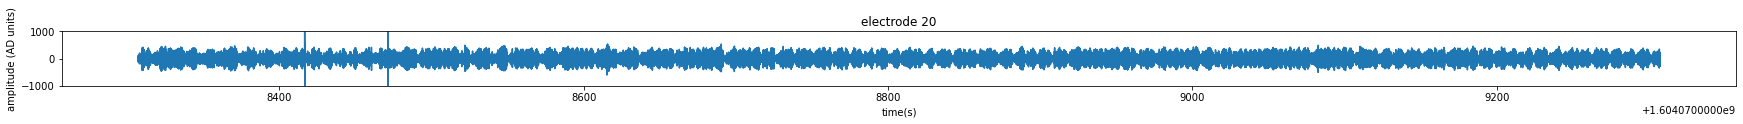

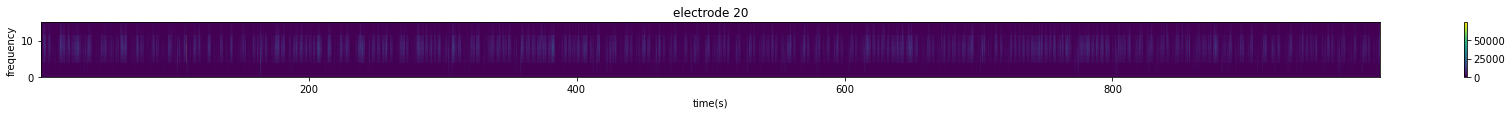

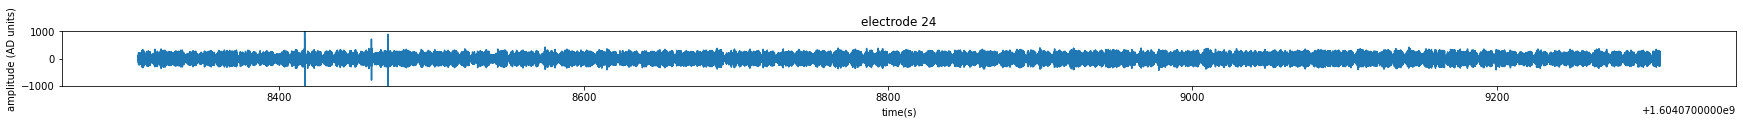

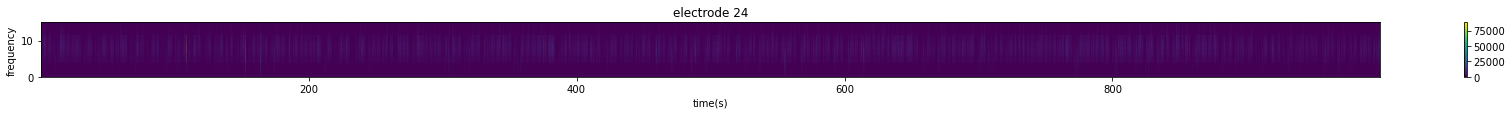

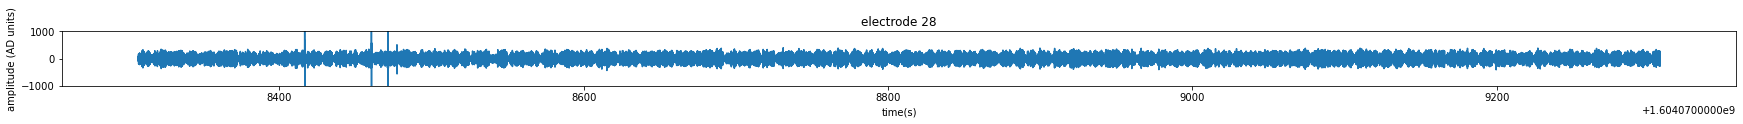

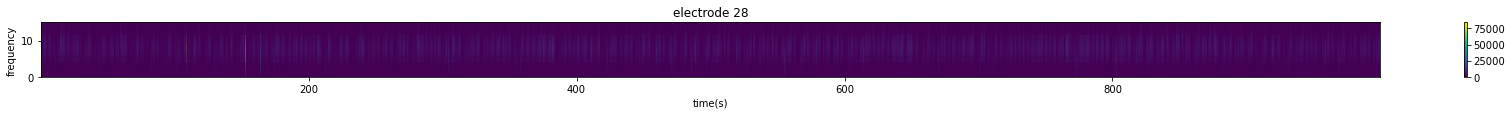

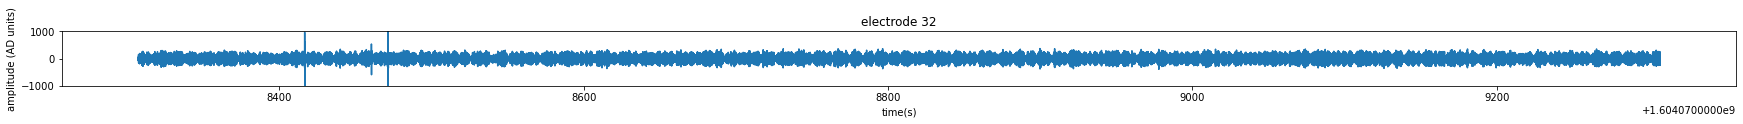

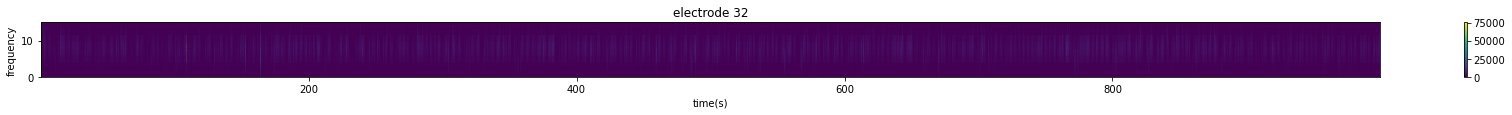

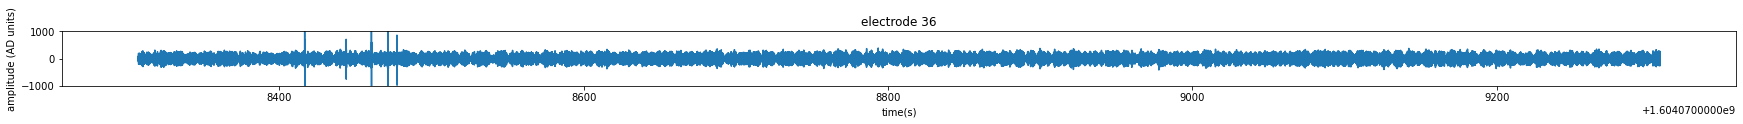

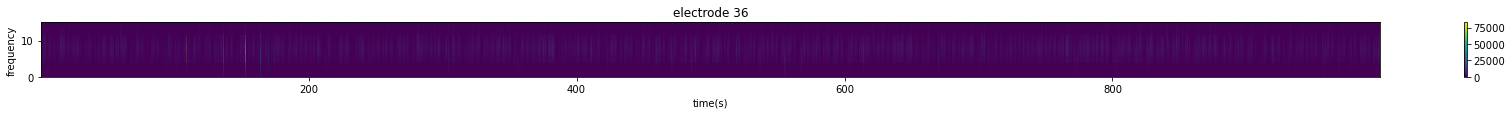

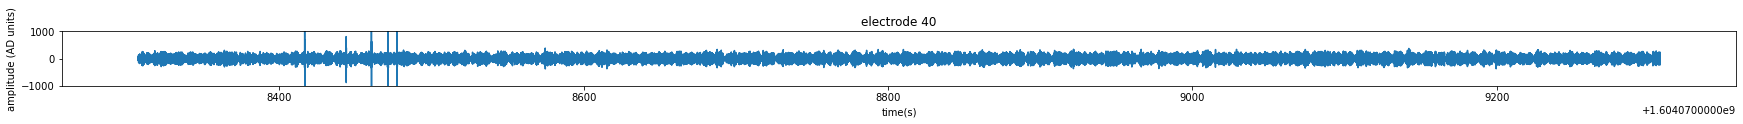

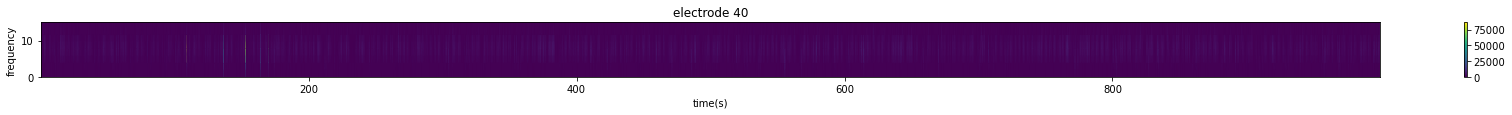

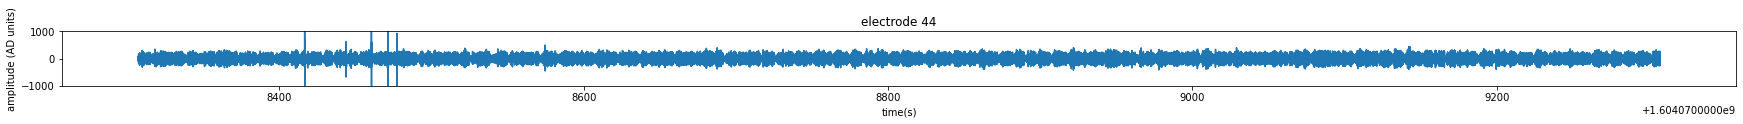

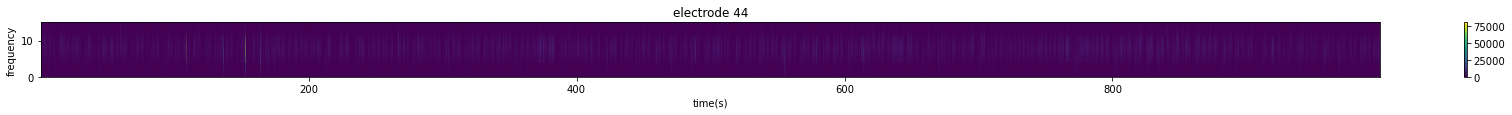

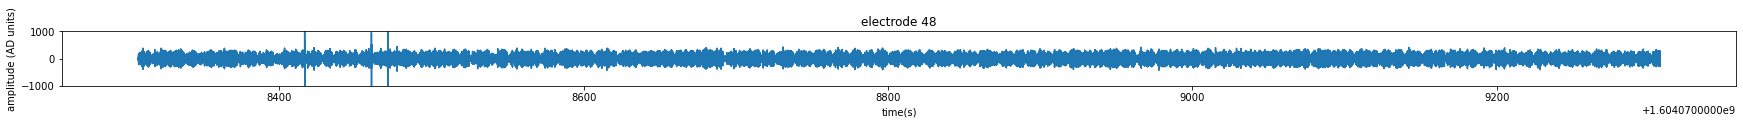

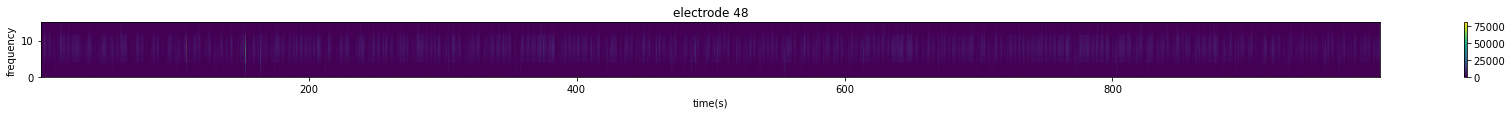

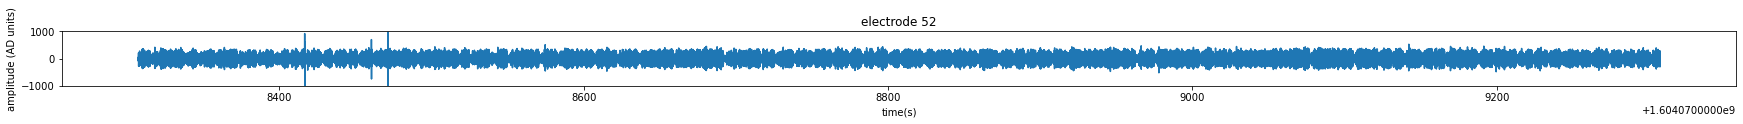

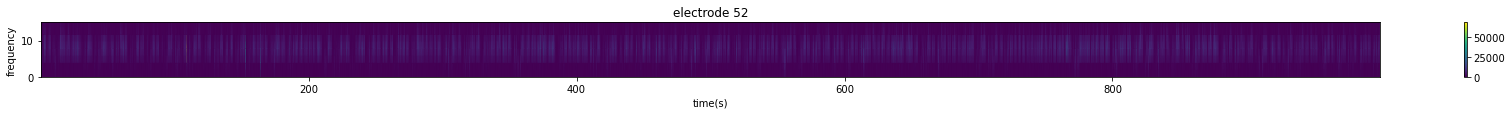

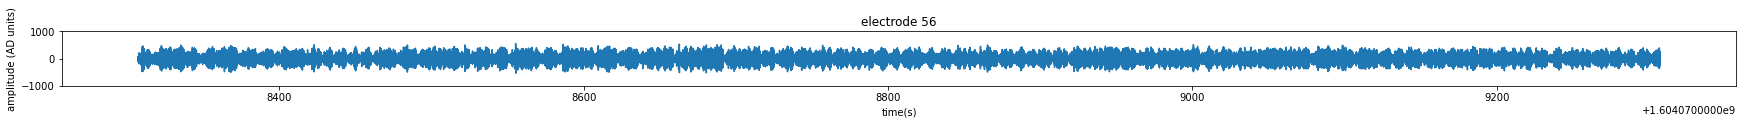

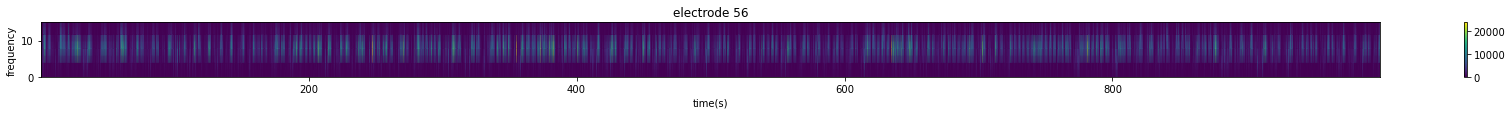

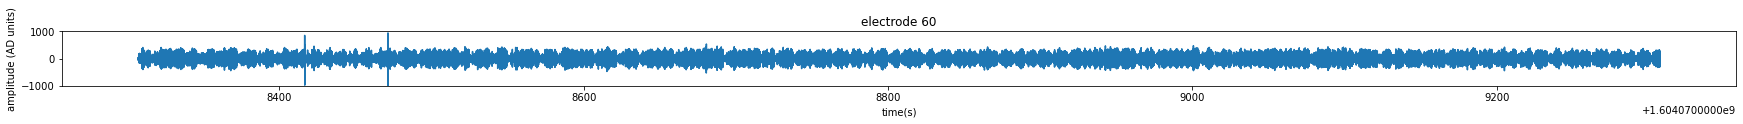

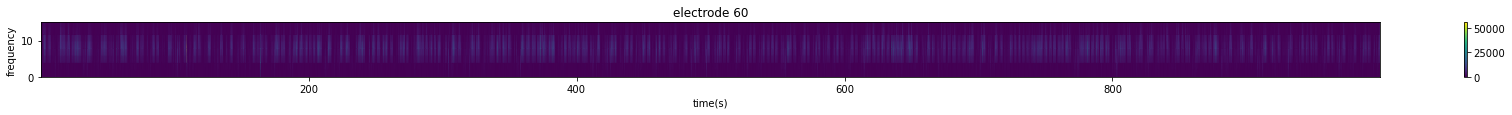

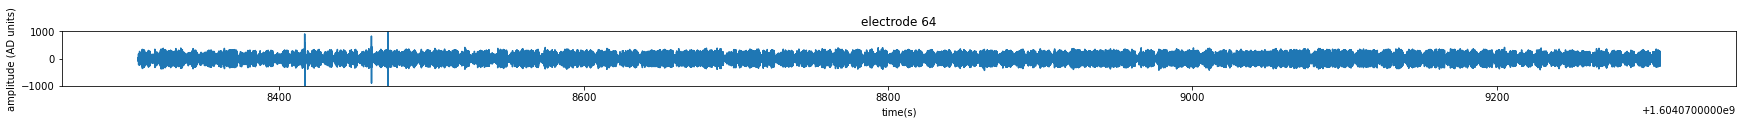

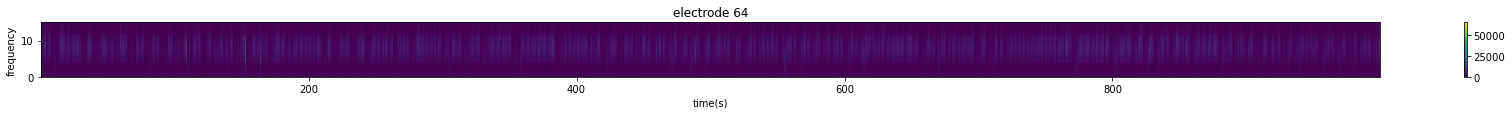

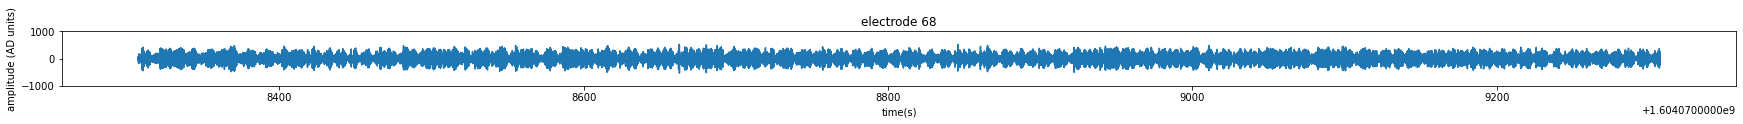

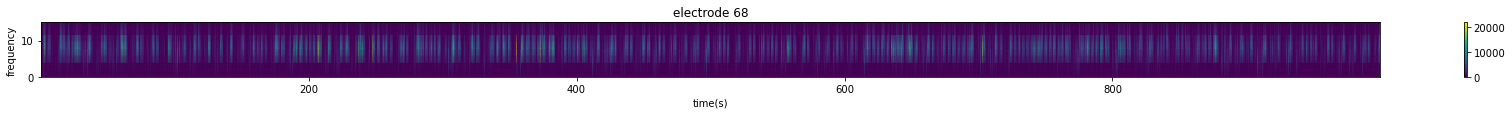

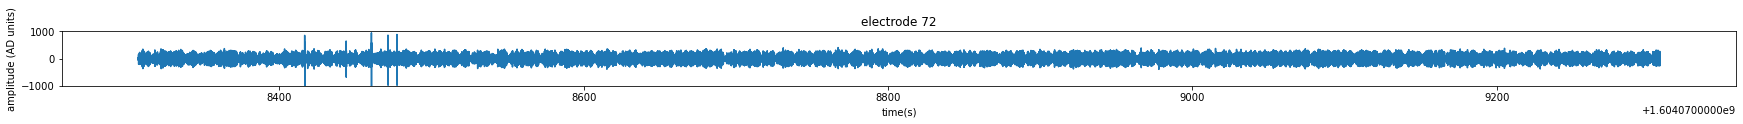

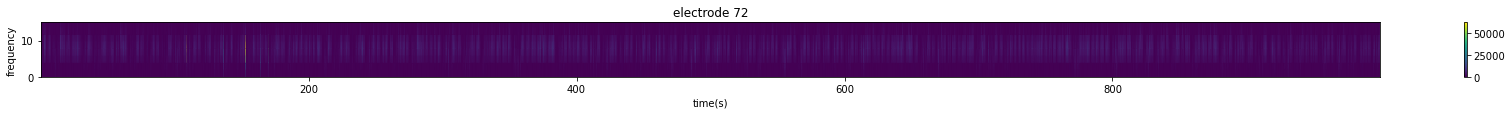

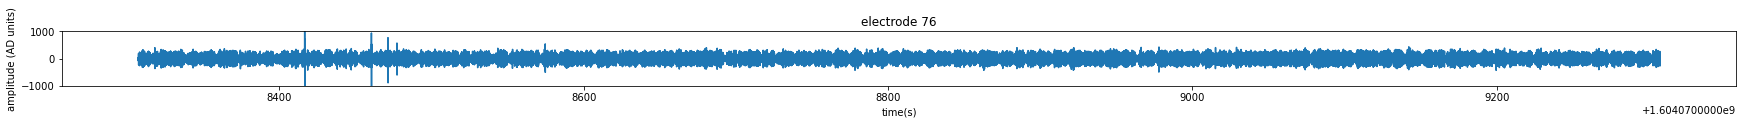

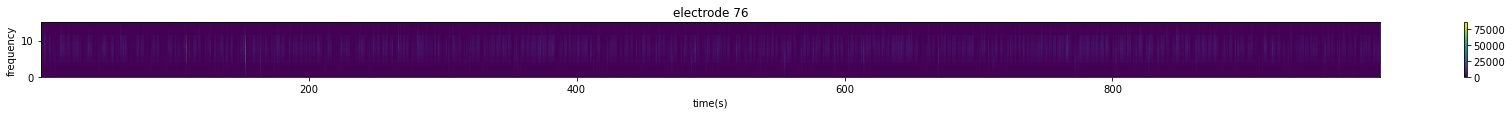

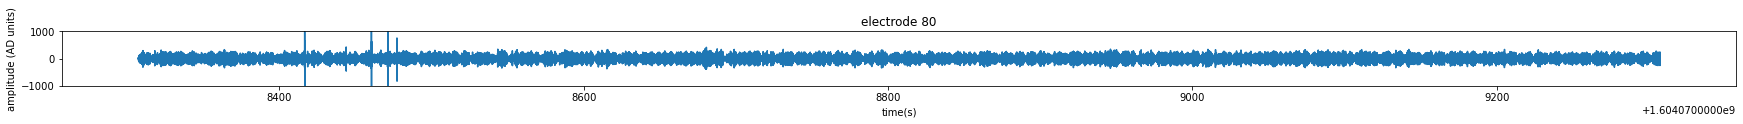

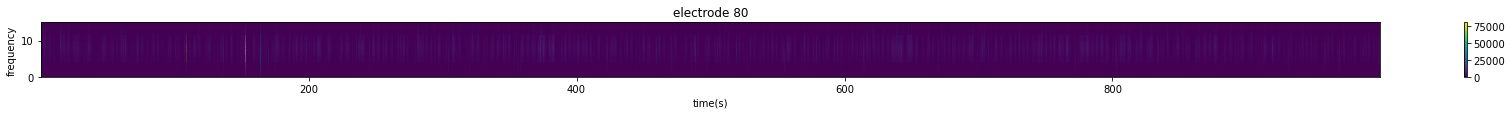

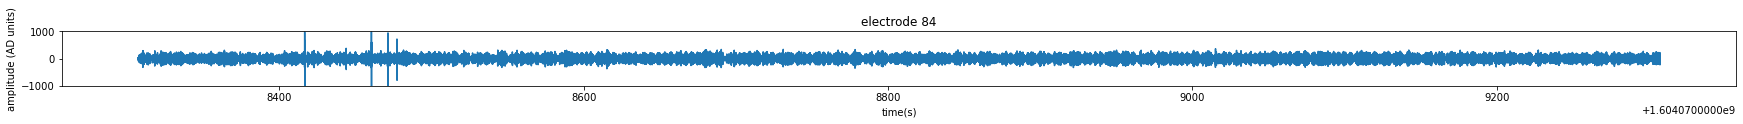

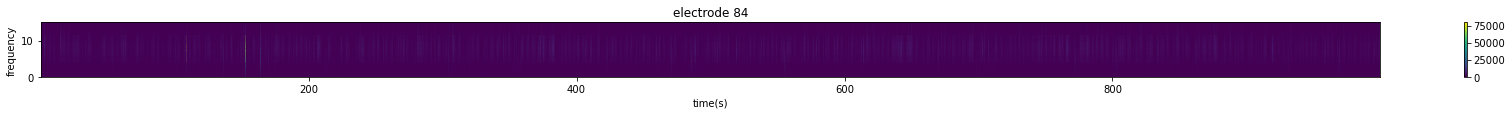

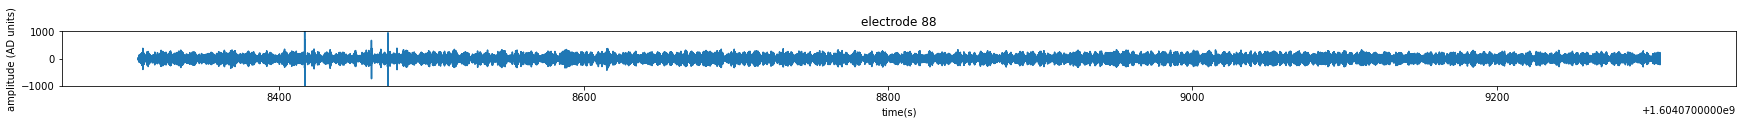

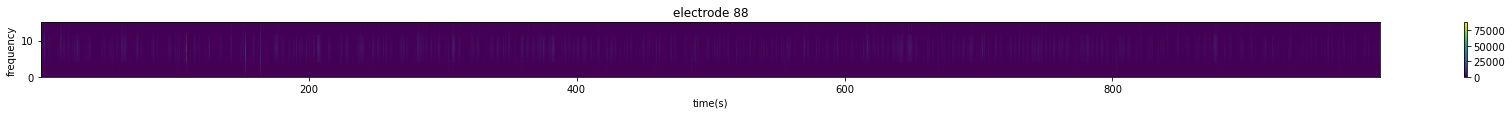

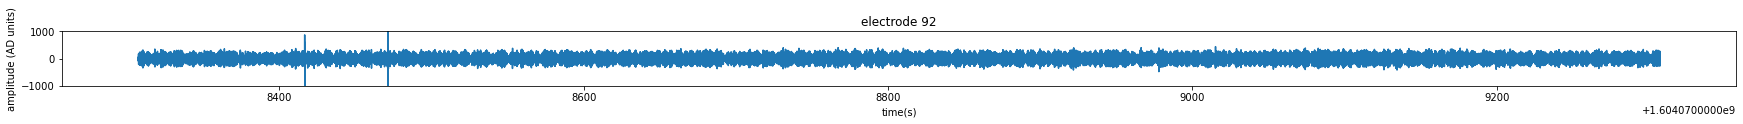

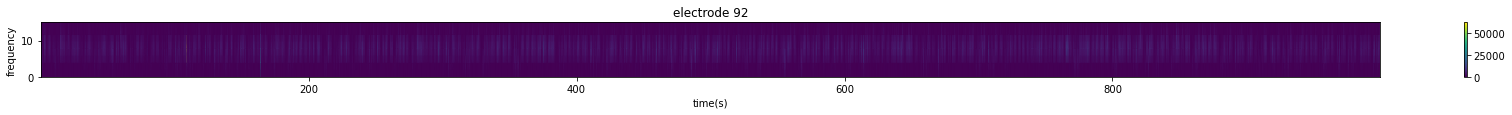

In [146]:
## plot the raw data over interval 
# %matplotlib inline
# for ix in range(len(x_elect_raw)):
#     plt.figure(figsize = (30,1))
#     plt.plot(x_elect_raw[ix],y_elect_raw[ix])
#     plt.title(f'electrode {lfp_electrode_ids_test[ix]}')
#     plt.xlabel('time(s)')
#     plt.ylabel('amplitude (AD units)')
#     plt.ylim(-1000,1000)


#plot the theta signal and power spectrum over interval time
%matplotlib inline
for ix in range(len(x_elect_theta)):
    plt.figure(figsize = (30,1))
    plt.plot(x_elect_theta[ix],y_elect_theta[ix])
    plt.title(f'electrode {theta_electrodes_test[ix]}')
    plt.xlabel('time(s)')
    plt.ylabel('amplitude (AD units)')
    plt.ylim(-1000,1000)
    plt.figure(figsize=(30,1))
    f, t, Sxx = sig.spectrogram(y_elect_theta[ix], 1000)
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.colorbar()
    plt.title(f'electrode {theta_electrodes_test[ix]}')
    plt.xlabel('time(s)')
    plt.ylabel('frequency')
    plt.ylim(0,15)
    # plt.ylim(-1000,1000)

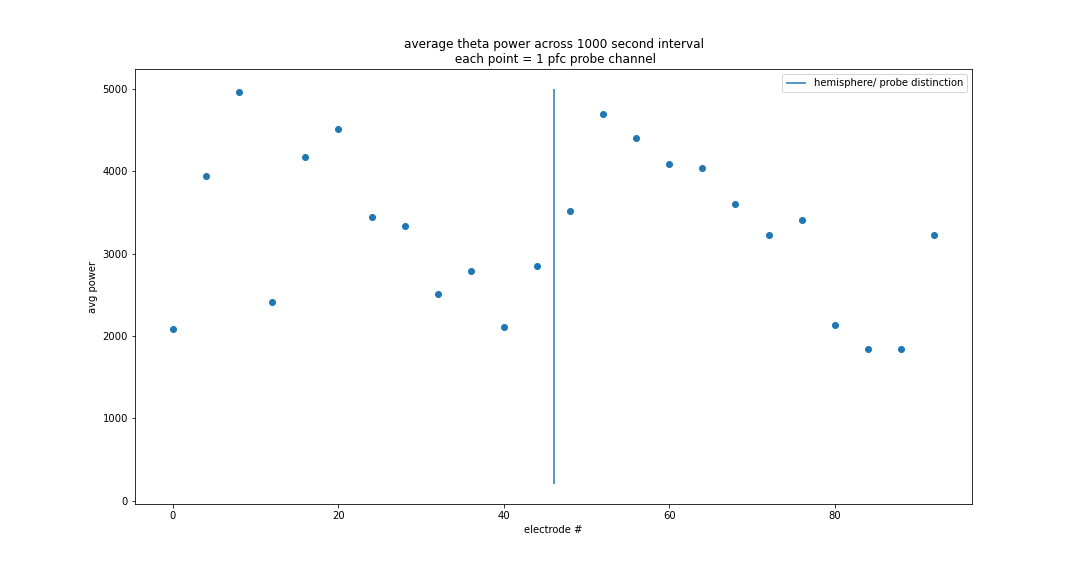

In [150]:
%matplotlib widget
elecs_freq_8_power_mean=[]
for ix in range(len(x_elect_theta)):
    f, t, Sxx = sig.spectrogram(y_elect_theta[ix], 1000)
    one_freq = Sxx[(f>7.5) & (f<9)][0]
    one_f_elec_mean =  statistics.mean(one_freq)
    elecs_freq_8_power_mean.append(one_f_elec_mean)
plt.figure(figsize=(15,8))
plt.scatter(theta_electrodes_test,elecs_freq_8_power_mean)
plt.vlines(theta_electrodes_test.max()/2,200,5000,label='hemisphere/ probe distinction')


#pfc vline
# plt.vlines(theta_electrodes_test.max()/2+128/2,200,400,label='hemisphere/ probe distinction')
len(x_elect_theta)
plt.title(f'average theta power across {time_interval_s} second interval\n each point = 1 pfc probe channel')
plt.xlabel('electrode #')
plt.ylabel('avg power')
plt.legend()

128